In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time

In [24]:
df = pd.read_pickle('BASE PREPARADA MODELO.pkl')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 56 to 98373
Columns: 201 entries, target to MEPP_y_1
dtypes: float64(13), int8(188)
memory usage: 5.7 MB


In [26]:
# Define the search space for the hyperparameters
search_space = {
    'num_hidden_layers': [1, 2, 3, 4],
    'num_neurons': [32, 64, 128, 256],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 150],
}

# Define the fitness function that will evaluate each set of hyperparameters
def evaluate_fitness(hyperparameters, X_train, y_train, X_test, y_test):
    num_hidden_layers = hyperparameters['num_hidden_layers']
    num_neurons = hyperparameters['num_neurons']
    learning_rate = hyperparameters['learning_rate']
    batch_size = hyperparameters['batch_size']
    epochs = hyperparameters['epochs']
    
    # Build the neural network model
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
    for i in range(num_hidden_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Train the model and evaluate its performance on the validation set
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_test, y_test), callbacks=[early_stopping])
    val_loss = np.min(history.history['val_loss'])
    
    # Return the negative validation loss as the fitness score
    return -val_loss

def run_genetic_algorithm(population_size, generations, X_train, y_train, X_test, y_test):
    # Initialize the population with random hyperparameters
    population = []
    for i in range(population_size):
        hyperparameters = {}
        for key, values in search_space.items():
            hyperparameters[key] = random.choice(values)
        population.append(hyperparameters)
    
    # Evolve the population for the specified number of generations
    for i in range(generations):
        # Evaluate the fitness of each individual in the population
        fitness_scores = []
        for individual in population:
            fitness_scores.append(evaluate_fitness(individual, X_train, y_train, X_test, y_test))
        
        # Select the parents for mating based on their fitness scores
        parents = []
        for j in range(2):
            parent_indices = np.random.choice(len(population), size=2, replace=False,
                                               p=np.exp(fitness_scores) / np.sum(np.exp(fitness_scores)))
            parents.append(population[parent_indices[0]])
            parents.append(population[parent_indices[1]])
        
        # Generate new offspring by crossover and mutation
        offspring = []
        for j in range(population_size - 2):
            child = {}
            for key in search_space.keys():
                if random.random() < 0.5:
                    child[key] = parents[0][key]
                else:
                    child[key] = parents[1][key]
                if random.random() < 0.1:
                    child[key] = random.choice(search_space[key])
            offspring.append(child)
        
        # Replace the old population with the new offspring
        population = parents + offspring
    
    # Evaluate the fitness of each individual in the final population
    fitness_scores = []
    for individual in population:
        fitness_scores.append(evaluate_fitness(individual, X_train, y_train, X_test, y_test))
    
    # Return the best individual found
    best_individual_index = np.argmax(fitness_scores)
    return population[best_individual_index]

In [27]:
ratio = 0.30

In [28]:
############### Com balanceamento com 3 classes###############

#Creating X and y:
X = df.drop(['target'], axis=1)
y = df['target']
#Data split into train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio)
print('Distribuição das classes:', Counter(y))

Distribuição das classes: Counter({0: 16883, 1: 3101})


In [29]:
############### Com balanceamento com 3 classes###############

# Cria objeto SMOTE
smote = SMOTE(random_state=42)

# Realiza oversampling das classes minoritárias
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verifica distribuição das classes após oversampling
print('Distribuição das classes após oversampling:', Counter(y_resampled))

#Data split into train and test:
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X_resampled, y_resampled, test_size=ratio)

Distribuição das classes após oversampling: Counter({0: 16883, 1: 16883})


In [30]:
# Example usage of evaluate_fitness and run_genetic_algorithm functions
population_size = 10
generations = 5

# Call the genetic algorithm to find optimal hyperparameters
best_individual = run_genetic_algorithm(population_size, generations,X_train_re, y_train_re, X_test_re, y_test_re)

# Evaluate the fitness of the best individual found
fitness_score = evaluate_fitness(best_individual, X_train_re, y_train_re, X_test_re, y_test_re)
print('Best individual:', best_individual)
print('Fitness score:', fitness_score)

Epoch 1/50
185/185 [==============================] - 1s 3ms/step - loss: 0.6323 - accuracy: 0.6437 - val_loss: 0.5933 - val_accuracy: 0.6577
Epoch 2/50
185/185 [==============================] - 0s 2ms/step - loss: 0.5831 - accuracy: 0.6682 - val_loss: 0.5766 - val_accuracy: 0.6658
Epoch 3/50
185/185 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.6697 - val_loss: 0.5780 - val_accuracy: 0.6570
Epoch 4/50
185/185 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.6762 - val_loss: 0.5785 - val_accuracy: 0.6736
Epoch 5/50
185/185 [==============================] - 0s 2ms/step - loss: 0.5689 - accuracy: 0.6836 - val_loss: 0.5733 - val_accuracy: 0.6806
Epoch 6/50
185/185 [==============================] - 0s 2ms/step - loss: 0.5697 - accuracy: 0.6854 - val_loss: 0.5714 - val_accuracy: 0.6742
Epoch 7/50
185/185 [==============================] - 0s 2ms/step - loss: 0.5660 - accuracy: 0.6820 - val_loss: 0.5725 - val_accuracy: 0.6857
Epoch 

In [1]:
num_hidden_layers =  3
num_neurons =  64
learning_rate = 0.001
batch_size = 64
epochs = 100

In [2]:
# Build the neural network model
model = Sequential()
model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
for i in range(num_hidden_layers - 1):
    model.add(Dense(num_neurons, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model and evaluate its performance on the validation set
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])
val_loss = np.min(history.history['val_loss'])

NameError: name 'Sequential' is not defined

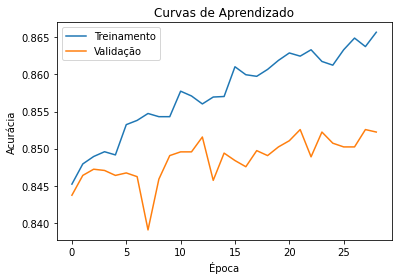

In [ ]:
import matplotlib.pyplot as plt

# plotar as curvas de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curvas de Aprendizado')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()


In [ ]:
# Printing out model metric reports
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))

188/188 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      5049
           1       0.61      0.18      0.28       947

    accuracy                           0.85      5996
   macro avg       0.74      0.58      0.60      5996
weighted avg       0.82      0.85      0.82      5996



In [ ]:
(y_pred > 0.7).astype(int)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

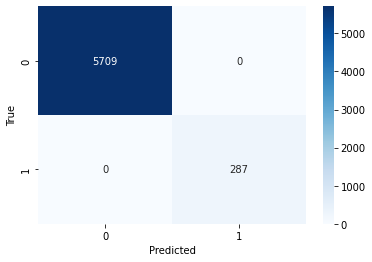

In [ ]:
# gerar a matriz de confusão
#cm = confusion_matrix(y_pred_classes, y_pred_classes)

cm = confusion_matrix(y_pred_classes, y_pred_classes)
# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# avaliar a rede neural nos dados de treinamento e validação
train_scores = model.evaluate(X_train, y_train, verbose=0)
val_scores = model.evaluate(X_test, y_test, verbose=0)

# imprimir as métricas de avaliação
print('Acurácia de Treinamento: %.2f%%' % (train_scores[1]*100))
print('Acurácia de Validação: %.2f%%' % (val_scores[1]*100))

Acurácia de Treinamento: 86.85%
Acurácia de Validação: 85.22%
